# Predator-prey dynamics

참조 : <a href="https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations" target="_blank">https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations</a>

#### predator-prey 모델은 같이 살고 있는 생태계에서 제한된 자원을 놓고 포식자와 피식자간의 개체군 역학(population dynamics)을 시뮬레이션 한다.

이 예제는 이종 행위자(혼합 행위자 기반 모델 (`mixed agent based model`))를 사용하여 모델을 개발하는 방법,
역학에서 공간적 특성의 통합, 하나의 gird 좌표에 여러 행위자(agent)가 허용되는 `GridSpace`의 사용법을 설명한다. 

#### 모델설명
환경은 양(sheep), 늑대(wolf), 풀(grass)가 있는 2차원 그리드 이다.\
모델에서 늑대는 양을 먹고 양은 풀을 먹는다.\
자원의 균형이 잘 맞으면 개체군의 수는 시간에 따라 늘어났다 줄었다 진동하게 되는데 자원 균형이 무너지면 개체군은 멸종 할 수 있다.\
예를들어, 늑대가 너무 많아 지면 양이 고갈되고 결국 늑대는 굶어 죽는다.

늑대(`Wolf`),양(`Sheep`)은 행위자(agent)이고 풀(`grass`)은 모델에서 공간적 속성이다.\
늑대와 양은 동일한 속성을 가지지만 다른 행위를 한다.\
에너지(`energy`) 속성은 늑대와 양의 현재 에너지 레벨을 나타낸다.\
에너지 레벨이 0 이하가 되면 행위자는 죽는다.\
이 모델에서 늑대와 양은 주어진 재생산확률(`reproduction_prob`)로 무성생식을 한다.\
`Δenergy` 속성은 음식을 섭취한 후 획득하는 에너지의 양을 제어한다.

풀(`grass`)은 grid space의 모든 위치에서 계속 채워지는 자원이다.\
풀은 완전히 자란 경우(`fully_grown`)에만 먹을 수 있다.\
풀이 소모되면 재성장(`regrowth_time`) 속성으로 지정된 시간이 지난후 다시 채워진다.\
`countdown` 속성은 풀이 소모된후 재성장하는 시간의 지연을 추적 한다.


 소스 : <a href="https://github.com/mrchaos/julia_agents_examples" target="_blank">https://github.com/mrchaos/julia_agents_examples</a>
 
 ## 동작 환경
- Julia   : v1.7.2
- Agents  : v5.5.0
- InteractiveDynamics : v0.21.11
- GLMakie : v0.6.13
- CairoMakie : v0.8.13



- GLMakie를 사용하고 싶은 경우 설정에 대해서는 <a href="https://julialang.kr/?p=3684" target="_blank">https://julialang.kr/?p=3684</a> 를 참조

In [1]:
using Agents
using Random
using LinearAlgebra

### Define Agent Structure

In [2]:
@agent Animal GridAgent{2} begin
    energy::Float64
    reproduction_prob::Float64
    Δenergy::Float64    
end

In [3]:
@agent Sheep Animal begin end
@agent Wolf Animal begin end

### Initialize Model

In [4]:
function initialize_model(;
        n_sheep = 100,
        n_wolves = 50,
        dims = (50, 50),
        regrowth_time = 30,
        Δenergy_sheep = 4,
        Δenergy_wolf = 30,
        sheep_reproduce = 0.04,
        wolf_reproduce = 0.05,
        seed = 23182
    )
    rng = MersenneTwister(seed)
    space = GridSpace(dims, periodic = true)
    
    ## 모델 속성으로 풀이 완전히 다자란 풀과 다시 자라는 걸리는 시간을 나타내는 배열 2개를 포함하고
    ## statici parameter로 풀의 재생시간을 나타내는 `regrowth_time`을 포함한다.
    ## 속성은 `NamedTuple`로 나타낸다.
    
    properties = (
        fully_grown = falses(dims),
        countdown = zeros(Int, dims),
        regrowth_time = regrowth_time,
    )
    
    # 모델 생성
    model = ABM(Union{Sheep, Wolf}, space;
        properties, rng, scheduler = Schedulers.Randomly(), warn = false)
    
    # 모델에 agent 추가
    for _ in 1:n_sheep
        # 초기 에너지를 음식에서 획득하는 에너지의 2배를 에너지로 설정 한다.          
        energy = rand(model.rng, 1:(Δenergy_sheep*2)) - 1
        add_agent!(Sheep, model, energy, sheep_reproduce, Δenergy_sheep)
    end
    
    for _ in :1:n_wolves
        energy = rand(model.rng, 1:(Δenergy_wolf*2)) - 1
        add_agent!(Wolf, model, energy, wolf_reproduce, Δenergy_wolf)
    end
    
    # 모델에 grass추가
    # 모델의 모든 grid좌표에 풀의 속성을 저장한다.
    for p in positions(model)
        fully_grown = rand(model.rng, Bool)
        # 풀이 다자란 경우 풀이 다시 자라기 시작하는 시간을 regrowth_time 이 후 부터
        # 풀이 자라고 있는 경우 0 ~ regrowth_time-1 사이의 지연 시간을 설정
        countdown = fully_grown ? regrowth_time : rand(model.rng, 1:regrowth_time) - 1
        #  예) p = (2,3)
        model.countdown[p...] = countdown
        model.fully_grown[p...] = fully_grown
    end
    return model
end

initialize_model (generic function with 1 method)

### Defining Stepping

* 양과 늑대는 유사하게 행동한다.
* 양과 늑대는 근처 위치로 옮겨 갈때 마다 1에너지를 사용하고 가용한 음식을 섭취한다.
  - 늑대의 경우 이동한 위치에 양이 있어면 양을 잡아 먹는다.
  - 양의 경우 이동한 위치에 풀이 있어면 풀을 뜯어 먹는다.
* 에너지 레벨이 0 이하가 되면 죽는다 그게 아니면 살아 있고 주어진 재생산 확률로  번식한다.
* 양과 늑대는 `walk!` function으로 근처로 무작위로 이동한다.

#### 이동
* 이동 : 무직위로 근처로 이동
* 먹기 : 이동한 장소에 먹이가 있으면 먹는다
* 번식 : 주어진 번식 확률로 번식 한다.

<!--
```
function rot2D(θ::Float64) 
    Matrix{Float64}([cos(θ) -sin(θ);sin(θ) cos(θ)] )
end
```
-->

<!--
```
# Agent가 주어진 특정 방향 범위에서 무작위로 선택한다.
# agent가 특정 방향이 없는 경우 단순 랜덤워크를 하게 되는데 
# 이 경우 근방에서 움직일 확률이 크고 근방의 먹이가 없는 경우 쉽게 굶어 죽는다
# 먼 거리 까지 탐험 하기 위해 특정 범위의 방향을 부여 한다.
# NetLogo에 move를 보면 -50 ~ 50 범위의 무작위 값을 선택 한다.
function rand_direction(agent::AbstractAgent,model::ABM,
        from_angle::Int64,to_angle::Int64)
     angle = rand(model.rng,from_angle:to_angle)
    θ = angle*π/180
    p1 = Vector{Float64}(collect(agent.pos))
    p2 = rot2D(θ)*p1
    # 회전후 1 step 
    p2_dist = norm(p2)
    p2_dist = (p2_dist != 0) ? p2_dist : 1
    p2_unit_vec = p2 ./ p2_dist 
    p2 = (p2_dist+1.0).* p2_unit_vec
    # direction vector
    d_vec = p2 .- p1
    # 정규화
    dist = norm(d_vec)        
    d_vec = (dist != 0) ? d_vec ./dist : (0,0)
    # d_vec을 -1,0,1 값을 가지도록 한다
    # 최종 grid direction
    Tuple(Int64.(round.(d_vec)))
end
```
-->

In [5]:
function first_sheep_in_position(pos, model)
    # 선택된 grid에 있는 양과 늑대의 id 목록을 가지고 온다.
    ids = ids_in_position(pos, model)
    # 가져온 id 목록에서 첫번째 양의 index를 가져온다.
    j = findfirst(id -> model[id] isa Sheep, ids)
    # id 목록에서 첫번째 양의 index에 해당하는 양의 id를 찾아서
    # 해당 양을 가지고 온다.
    isnothing(j) ? nothing : model[ids[j]]::Sheep
end

function eat!(sheep::Sheep, model)
    # 다자란 풀만 먹는다
    if model.fully_grown[sheep.pos...]
        # 풀먹고 에너지 획득
        sheep.energy += sheep.Δenergy
        # 풀이 있었던자리에 풀을 먹을 수 없음을 표시
        model.fully_grown[sheep.pos...] = false
    end
    return
end

function eat!(wolf::Wolf, sheep::Sheep, model)
    # 늑대 먹이가 된 양은 죽음으로 처리
    kill_agent!(sheep, model)
    # 늑대가 추가적인 에너지를 얻는다.
    wolf.energy += wolf.Δenergy
    return
end

eat! (generic function with 2 methods)

### <font color=red>※ 주의: 아주 중요 - 아래 상항으로 해야 모델이 정상 동작 함</font>
#### walk!(sheep, rand, model) 는 기본적으로 옮기려고 하는 자리에 agent가 있어면 그 자리로 이동하지 않음
* Agent step시에 양의 경우 옮기려고 하는 위치에 양이나 늑대가 있어면 옮기기 않고 그 자리에 그대로 있는다. (양이 중첩되어 늑대의 먹이가 될 확률이 낮아 지는것을 방지). 
    - <font color=red>walk!(sheep, rand, model)</font>
* 늑대는 이동시 다른 늑대나 양이 있어도 그 자리로 이동한다. 옮긴 자리에 양이 있는 경우 먹을 수 있기 때문
    - <font color=red>walk!(wolf, direction, model;ifempty=false)</font>
* <font color=red>walk2! : 새로 만듬 </font>
    - 옮기려고 하는 곳에 같은 종류만 없어면 옮길 수 있다.

In [18]:
function walk2!(agent::A,model) where {A<:AbstractAgent}           
    direction = Tuple(rand(model.rng, -1:1, 2))    
    target = normalize_position(agent.pos .+ direction, model)
    
    # 선택된 grid에 있는 양과 늑대의 id 목록을 가지고 온다.
    ids = ids_in_position(target, model)
    # 가져온 id 목록에서 첫번째 A agent index를 가져온다.
    j = findfirst(id -> model[id] isa A, ids)
    # A agent가 없어면 움직인다
    isnothing(j) && move_agent!(agent, target, model)
end
    
function sheepwolf_step!(sheep::Sheep, model)
    # 양은 다른양/늑대가 없는 완전히 빈 공간으로만 이동
#     walk!(sheep, rand, model)
    walk2!(sheep, model)
    # 에너지 1소비
    sheep.energy -= 1
    # 에너지가 0보다 작으면 양은 죽는다.
    if sheep.energy < 0
        kill_agent!(sheep, model) # 내장 함수
        return
    end
    ## 이동한 지역에 먹을것이 있는 경우 먹는다.
    eat!(sheep, model)
    ## 재생산 확률로 번식한다.
    if rand(model.rng) ≤ sheep.reproduction_prob
        reproduce!(sheep, model)
    end
end

function sheepwolf_step!(wolf::Wolf, model)
#     walk!(wolf, rand, model;ifempty=false)
    walk2!(wolf, model)
    wolf.energy -= 1
    if wolf.energy < 0
        kill_agent!(wolf,model)
        return
    end
    ## 옮긴 지역에 양이 있는 경우 잡아 먹는다.
    dinner = first_sheep_in_position(wolf.pos, model)
    !isnothing(dinner) && eat!(wolf, dinner, model)
    ## 재생산
    if rand(model.rng) ≤ wolf.reproduction_prob
        reproduce!(wolf, model)
    end
end

sheepwolf_step! (generic function with 2 methods)

#### 먹기
* 양과 늑대는 서로 먹이가 다름으로 각각 eat! function을 정의 한다.
* 양이 풀을 먹으면 추가적인 에너지를 얻고 풀은 재성장 시간이 흘러 다 자랄때 까지 먹지 못한다.
* 늑대가 양을 먹으면 양은 죽고 늑대는 추가적인 에너지를 얻는다.

#### 번식(재생산)
##### 양과 늑대
* 양과 늑대는 재생산 방법 공유한다.
* 재생산에는 부모의 현재 에너지의 1/2을 사용한다.(즉 자식에게 에너지 절반을 준다)
* 자식은 `id`를 제외하고 부모와 동일한 복제본 이다.

##### 풀
* 풀이 완전히 자라면 먹을 수 있다.
* 재성장 시간 `regrowth_tile`에 설정된 시간이 지나야 먹을 수 있다.
* 풀은 환경에 속하기 때문에 model_step! function이다.

In [19]:
function reproduce!(agent::A, model) where {A}
    agent.energy /= 2
    offspring = deepcopy(agent)
    offspring.id = nextid(model)    
#     id = nextid(model)
#     offspring = A(id, agent.pos, agent.energy, agent.reproduction_prob, agent.Δenergy)
    add_agent_pos!(offspring,model)
    return
end

reproduce! (generic function with 1 method)

In [20]:
function grass_step!(model)
    @inbounds for p in positions(model) # @inbounds: 배열의 경계 체크를 끊다
        # 풀이 다 자라지 않은 경우
        if !(model.fully_grown[p...])
            # 풀이 다 성장한 경우 성장완료 표시, countdown에 재성장 시간을 다시 설정 한다.
            if model.countdown[p...] ≤ 0
                model.fully_grown[p...] = true
                model.countdown[p...] = model.regrowth_time
            # 풀이 다 성장 하지 않은 경우 countdown을 차감 하여 성장하고 있음을 나타냄
            else
                model.countdown[p...] -= 1
            end
        end
    end
end

grass_step! (generic function with 1 method)

### 모델 실행
* 500 step 동안 모델을 실행하고 매 스텝마다 양,늑대,먹을 수 있는 풀이 있는 자리를 기록 한다.

In [21]:
using InteractiveDynamics
using CairoMakie
CairoMakie.activate!()

* 초기에 시작하는 양과 늑대, 풀의 개괄적인 plot을 보기 위해 `abmplot`을 사용한다.
* 양과 늑대에 대해 자세한 plot을 정의 한다.

In [22]:
# 양과 늑대가 완전히 겹쳐 보이지 않게 하기 위해 약간 이동한다.
# 양인 경우 왼쪽으로 0.1, 아래로 0 ~0.1 이동, 늑대는 반대로 이동
offset(a) = a isa Sheep ? (-0.01, -0.01*rand()) : (+0.01,+0.01*rand())

ashape(a) = a isa Sheep ? :circle : :utriangle
acolor(a) = a isa Sheep ? RGBAf(1.0, 1.0, 1.0, 0.8) :  RGBAf(0.2, 0.2, 0.2, 0.8)

# 풀은 heatmap 사용
# grasscolor(model) = model.countdown ./ model.regrowth_time
grasscolor(model) = model.fully_grown .* 1

heatkwargs = (colormap = [:brown, :green], colorrange=(0,1))

plotkwargs = (;
    ac = acolor,
    as = 15,
    am = ashape,
    offset,
    scatterkwargs = (strokewidth = 1.0, strokecolor = :black),
    heatarray = grasscolor,
    heatkwargs = heatkwargs,
)

(ac = acolor, as = 15, am = ashape, offset = offset, scatterkwargs = (strokewidth = 1.0, strokecolor = :black), heatarray = grasscolor, heatkwargs = (colormap = [:brown, :green], colorrange = (0, 1)))

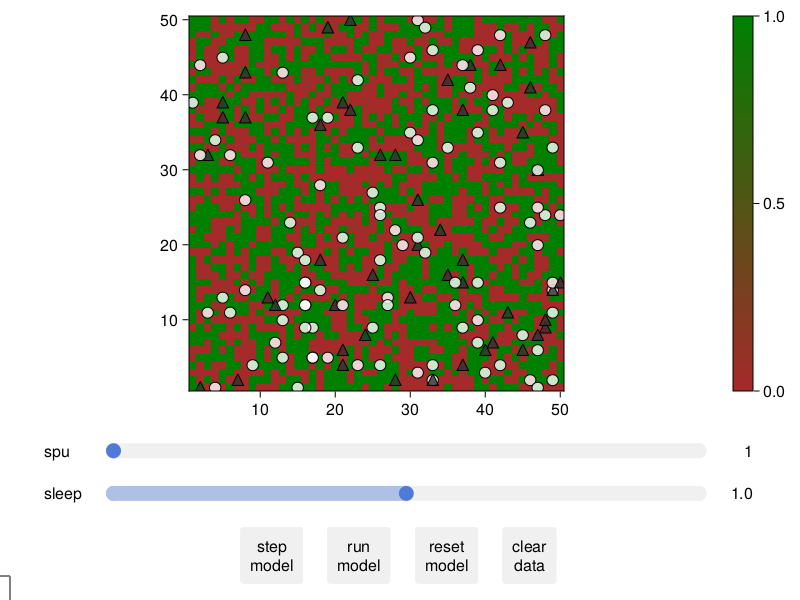

In [32]:
sheepwolfgrass = initialize_model(dims=(50,50))

fig, ax, abmobs = abmplot(sheepwolfgrass;
    agent_step! = sheepwolf_step!,
    model_step! = grass_step!,
    plotkwargs...)
fig

In [ ]:
let
    ENV["DISPLAY"]="localhost:11.0"
    using GLMakie
    GLMakie.activate!()
    
    sheepwolfgrass = initialize_model(
        dims=(50, 50),
        Δenergy_wolf = 30,
    )

    fig, ax, abmobs = abmplot(sheepwolfgrass;
        agent_step! = sheepwolf_step!,
        model_step! = grass_step!,
        plotkwargs...)
   
    display(fig)    
end

#### 시뮬레이셔 실행 및 데이터 수집

In [23]:
sheep(a) = a isa Sheep
wolf(a) = a isa Wolf
count_grass(model) = count(model.fully_grown)

count_grass (generic function with 1 method)

In [24]:
# Run dimulation
sheepwolfgrass = initialize_model(Δenergy_wolf = 30,)
steps = 2000
adata =[(sheep, count), (wolf, count)]
mdata = [count_grass]
adf, mdf = run!(sheepwolfgrass, sheepwolf_step!, grass_step!, steps; adata, mdata)

(2001×3 DataFrame
  Row │ step   count_sheep  count_wolf 
      │ Int64  Int64        Int64      
──────┼────────────────────────────────
    1 │     0          100          50
    2 │     1           94          52
    3 │     2           85          51
    4 │     3           83          52
    5 │     4           85          52
    6 │     5           85          54
    7 │     6           81          57
    8 │     7           79          56
    9 │     8           78          59
   10 │     9           74          59
   11 │    10           74          57
  ⋮   │   ⋮         ⋮           ⋮
 1992 │  1991          138          44
 1993 │  1992          138          45
 1994 │  1993          139          46
 1995 │  1994          134          44
 1996 │  1995          127          45
 1997 │  1996          127          47
 1998 │  1997          128          47
 1999 │  1998          126          49
 2000 │  1999          124          53
 2001 │  2000          120          53
         

In [25]:
function plot_population_timeseries(adf,mdf)
    fig = Figure(resolution=(800,600))
    ax = fig[1,1] = Axis(fig;xlabel = "Step", ylabel = "Population")
    sheep1 = lines!(ax,adf.step,adf.count_sheep, color = :cornsilk4)
    wolf1 = lines!(ax,adf.step,adf.count_wolf, color = RGBAf(0.2,0.2,0.3))
    grass1 = lines!(ax, mdf.step, mdf.count_grass ./4, color = :green)
    fig[1,2] = Legend(fig,[sheep1, wolf1, grass1],["Sheep","Wolf","Grass/4"])
    fig
end

plot_population_timeseries (generic function with 1 method)

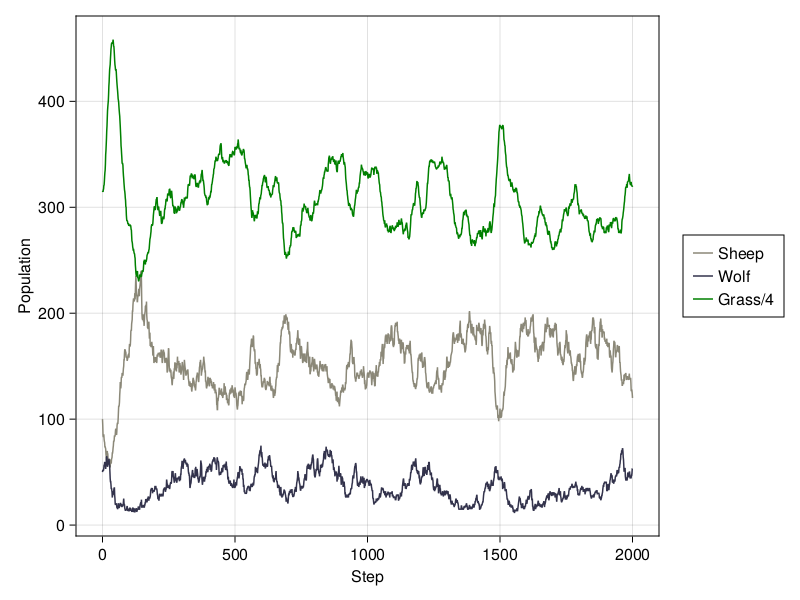

In [26]:
plot_population_timeseries(adf,mdf)

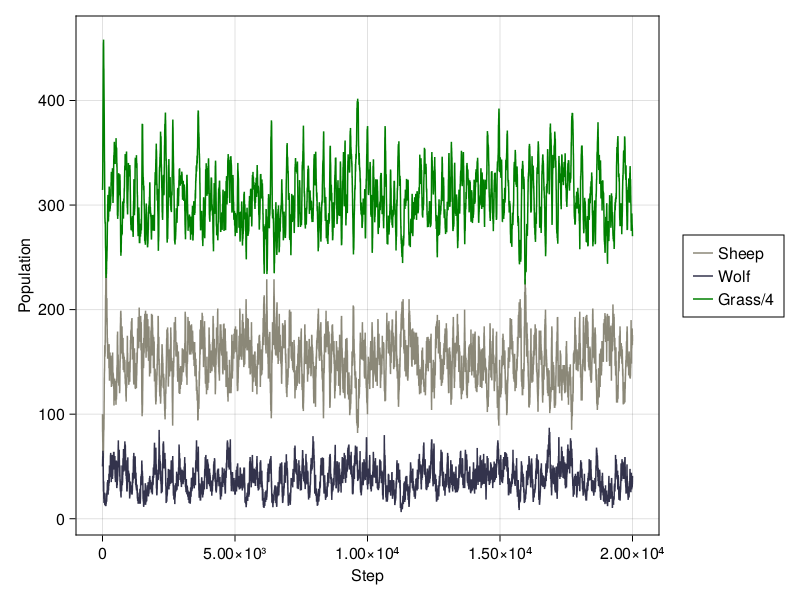

In [28]:
stable_params = (;
#     n_sheep = 100,
#     n_wolves = 50,
#     dims = (50, 50),
    Δenergy_wolf = 30,
#     seed = 71758,
)
sheepwolfgrass = initialize_model(;stable_params...)
adf, mdf = run!(sheepwolfgrass, sheepwolf_step!, grass_step!, 20000; adata, mdata)
plot_population_timeseries(adf,mdf)

In [ ]:
sheepwolfgrass = initialize_model(;stable_params...)
abmvideo(
    "sheepwolf.mp4",
    sheepwolfgrass,
    sheepwolf_step!,
    grass_step!;
    frames = 100,
    framerate = 8,
    title = "Sheep Wolf Grass",
    plotkwargs...,
)

<video width="auto" controls autoplay loop source src="sheepwolf.mp4" type="video/mp4"/>

In [29]:
using StatsBase

In [30]:
mean(adf.count_wolf),mean(adf.count_sheep),mean(mdf.count_grass)

(38.51652417379131, 152.1389930503475, 1230.2982850857456)

In [31]:
std(adf.count_wolf),std(adf.count_sheep),std(mdf.count_grass)

(12.568330813518083, 22.36505935529798, 113.61800615025297)